In [3]:
%pip install numpy matplotlib scipy pandas seaborn scikit-learn statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


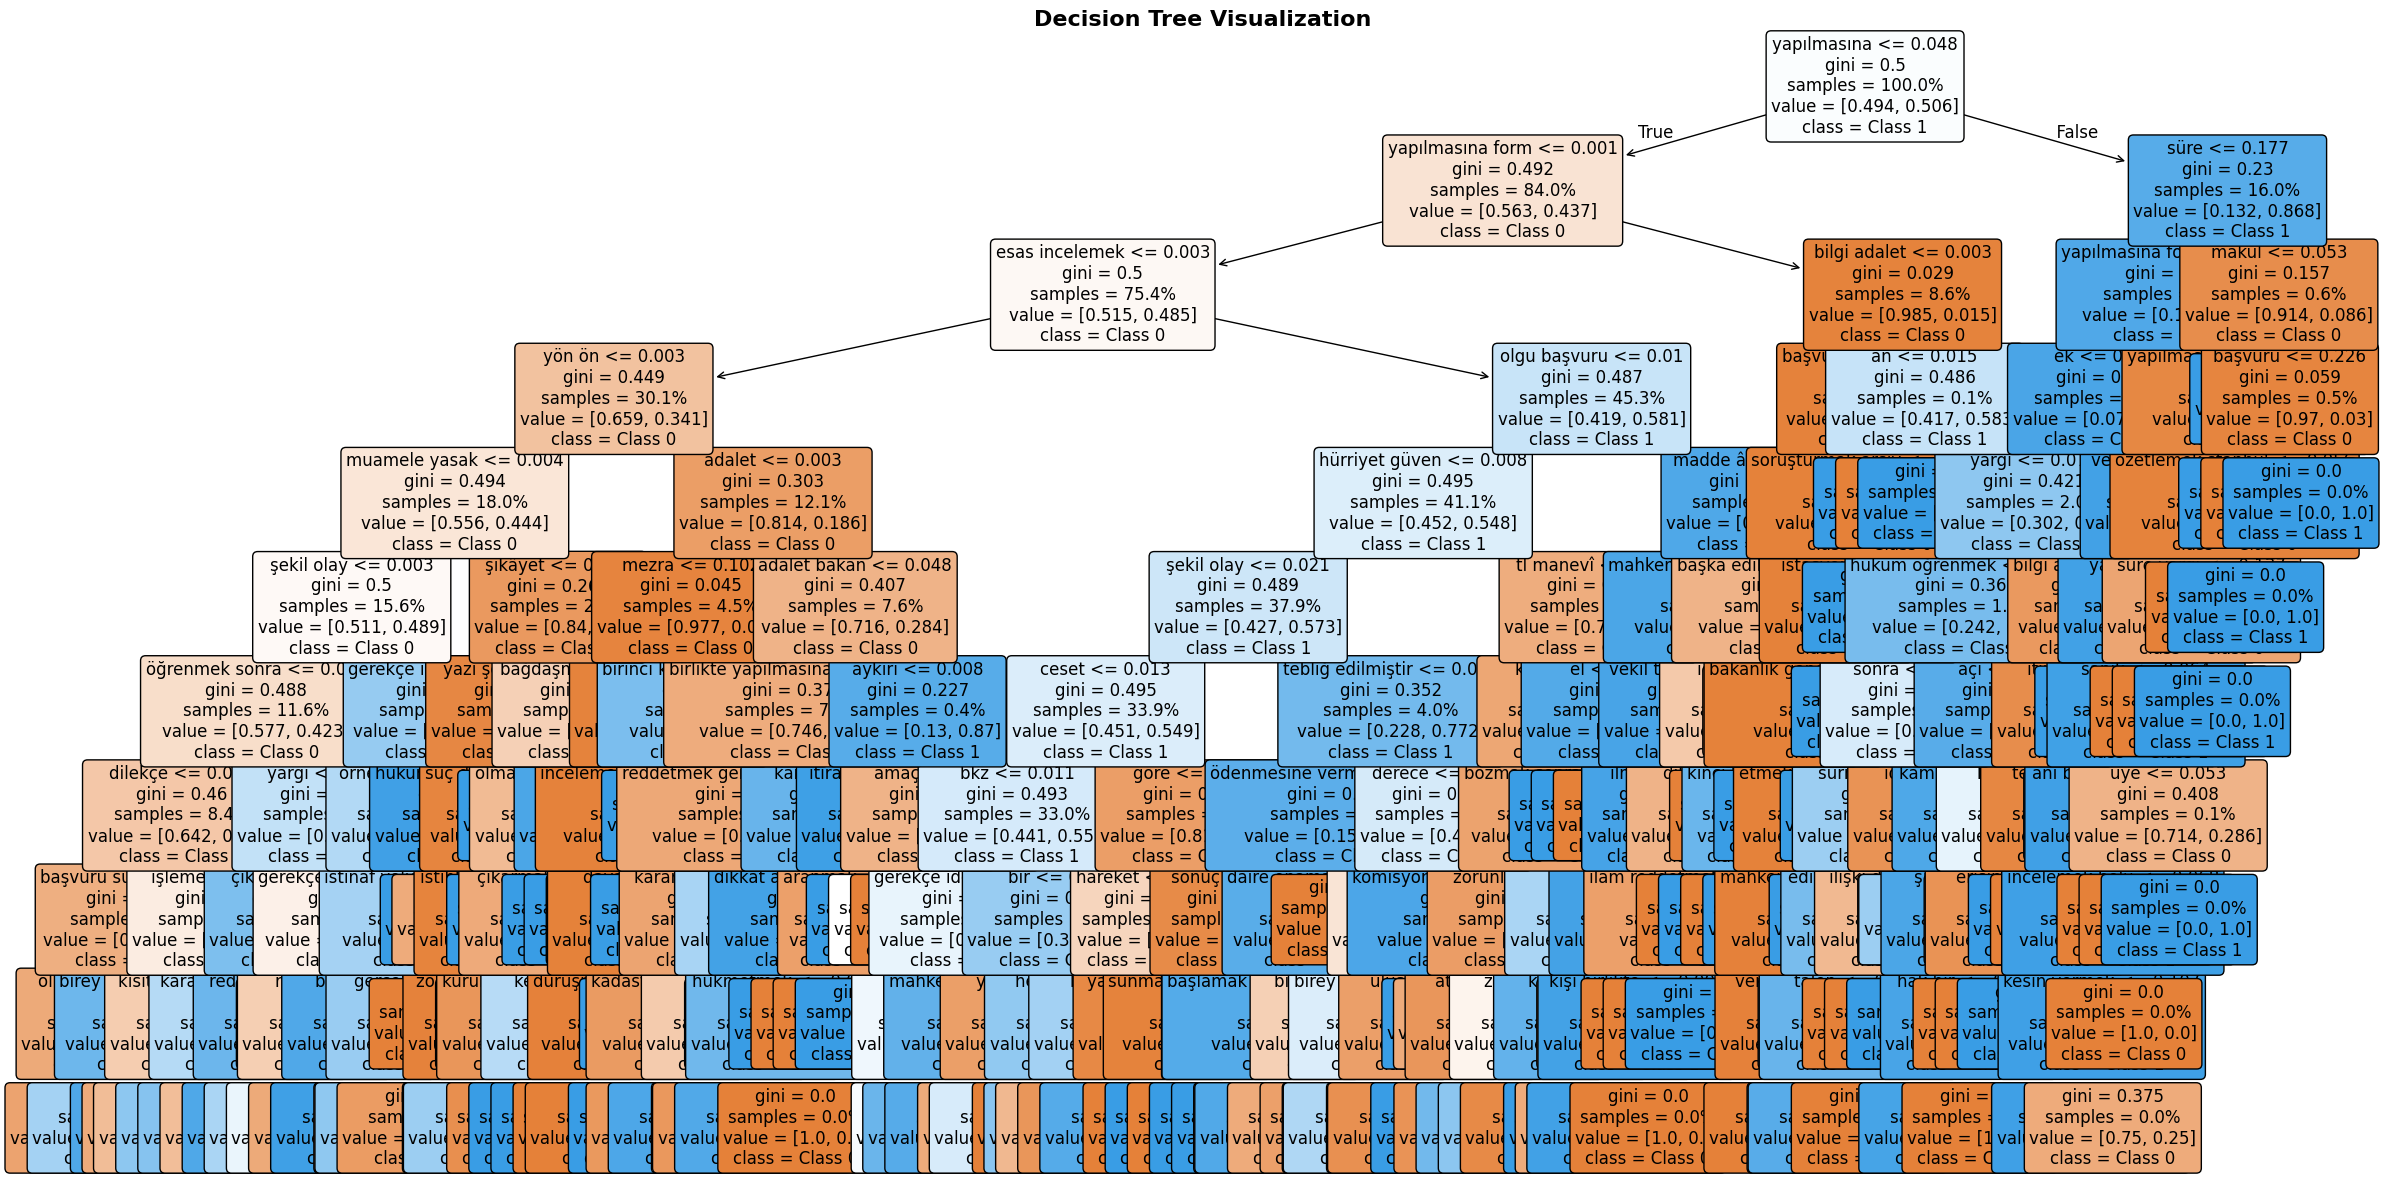

C:\Users\aazah\AppData\Local\Temp\ipykernel_16292\4061081621.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


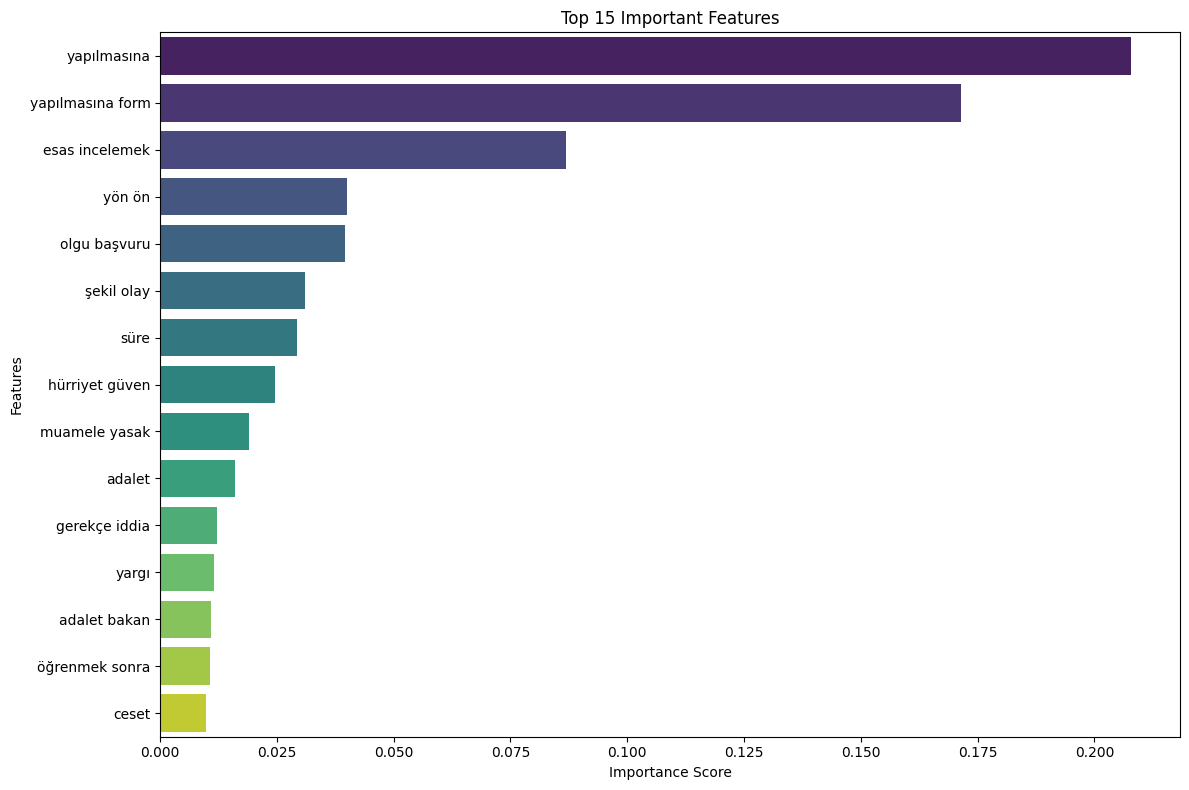

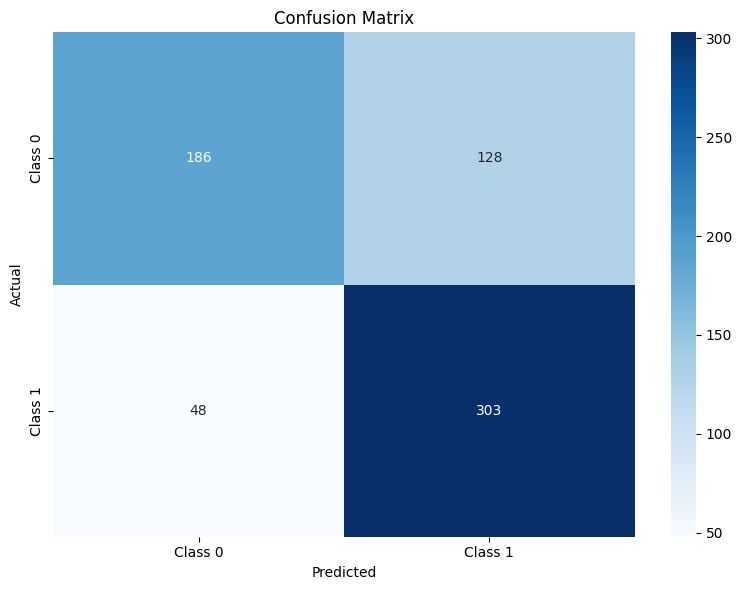

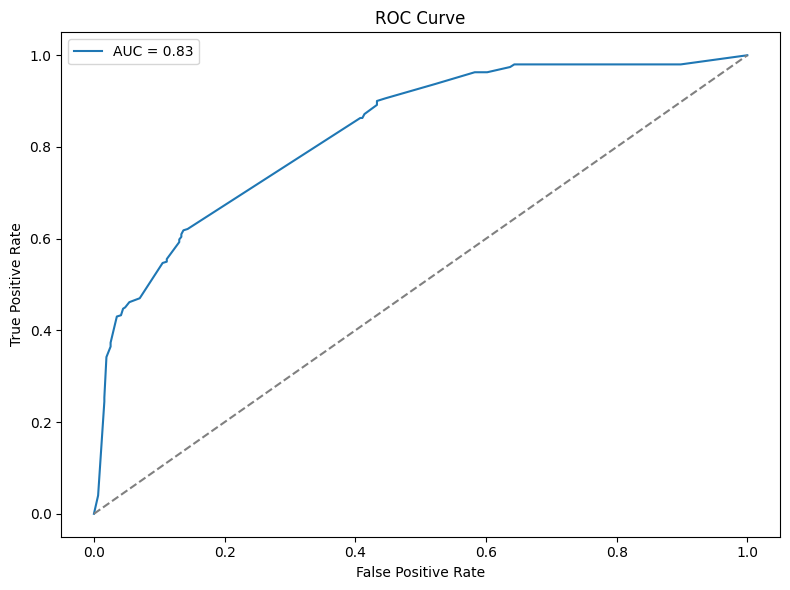

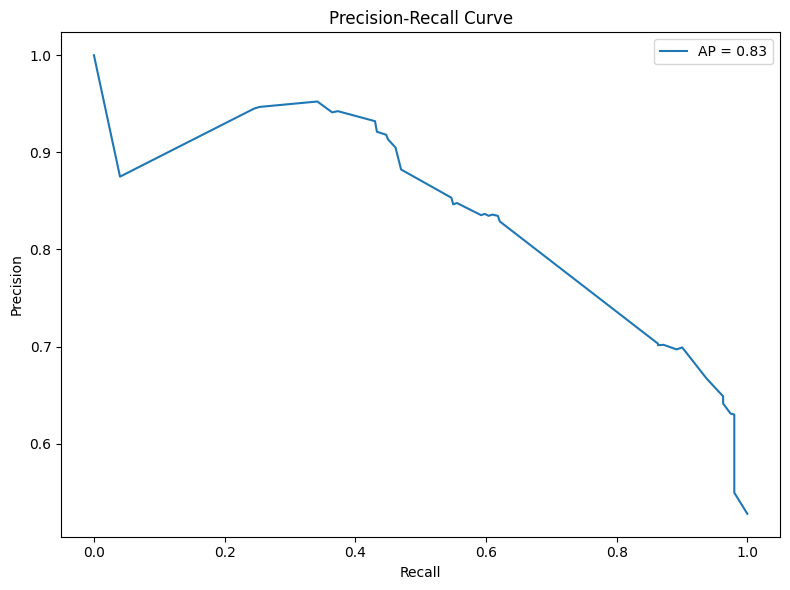

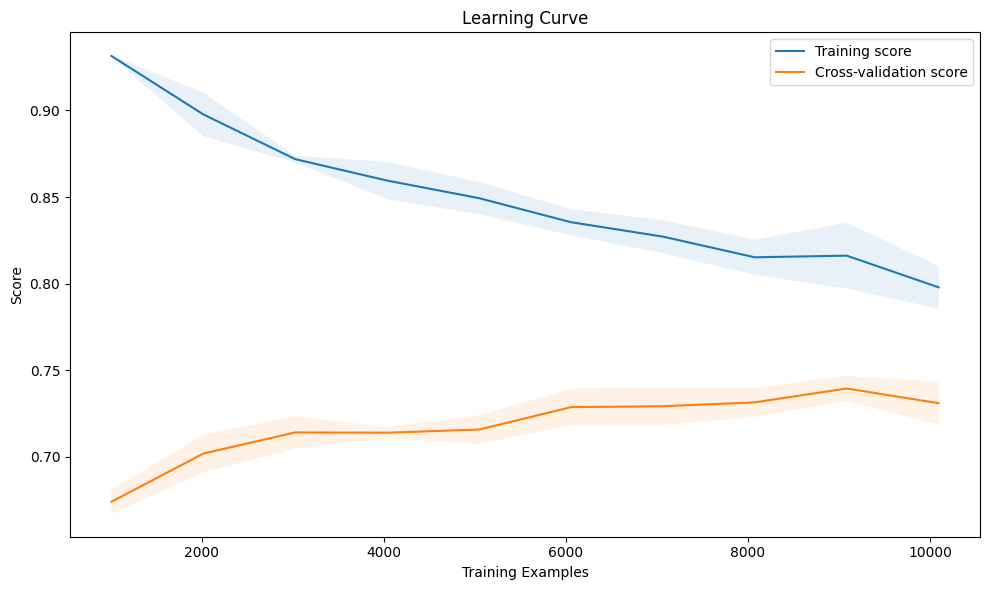


Generating classification metrics visualization...
Model Performance Summary
--------------------------------------------------
Accuracy: 0.735
ROC-AUC: 0.832
Cross-Validation Scores: [0.72118812 0.7155309  0.72860539 0.73969889 0.75198098]
Mean Cross-Validation Accuracy: 0.731

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       314
           1       0.70      0.86      0.77       351

    accuracy                           0.74       665
   macro avg       0.75      0.73      0.73       665
weighted avg       0.75      0.74      0.73       665



In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
from lime.lime_text import LimeTextExplainer

# Data Loading and Preprocessing
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return pd.DataFrame(json.load(file))

def prepare_features_and_labels(data, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        features = vectorizer.fit_transform(data['text'])
    else:
        features = vectorizer.transform(data['text'])
    labels = data['labels']
    return features, labels, vectorizer

# Load and prepare datasets
train_data = load_json_data('D:/Github Projects/Machine Learning in Law/Phase (2) - Data Processing & EDA/Preprocessed Data/training_dataset.json')
development_data = load_json_data('D:/Github Projects/Machine Learning in Law/Phase (2) - Data Processing & EDA/Preprocessed Data/development_dataset.json')
test_data = load_json_data('D:/Github Projects/Machine Learning in Law/Phase (2) - Data Processing & EDA/Preprocessed Data/testing_dataset.json')

X_train, y_train, vectorizer = prepare_features_and_labels(train_data)
X_dev, y_dev, _ = prepare_features_and_labels(development_data, vectorizer)
X_test, y_test, _ = prepare_features_and_labels(test_data, vectorizer)

X_combined = np.vstack([X_train.toarray(), X_dev.toarray()])
y_combined = np.hstack([y_train, y_dev])

# Train Decision Tree Model
model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, criterion='gini', random_state=40)
model.fit(X_combined, y_combined)

# Predictions and Probabilities
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

# Performance Metrics
accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)
roc_auc = roc_auc_score(y_test, probabilities)
cross_val_scores = cross_val_score(model, X_combined, y_combined, cv=5, scoring='accuracy')

# Decision Tree Visualization
plt.figure(figsize=(24, 12))
plot_tree(
    model,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True,
    fontsize=12,
    impurity=True,
    proportion=True
)
plt.title('Decision Tree Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature Importance Plot
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': model.feature_importances_
})
feature_importance = feature_importance.nlargest(15, 'importance')
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, probabilities)
avg_precision = average_precision_score(y_test, probabilities)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_combined, y_combined, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Export Decision Rules
rules = export_text(model, feature_names=vectorizer.get_feature_names_out())
with open('decision_tree_rules.txt', 'w', encoding='utf-8') as file:
    file.write(rules)

# Save Results
results = {
    'accuracy': accuracy,
    'roc_auc': roc_auc,
    'cross_val_scores': cross_val_scores.tolist()
}
with open('model_results.json', 'w') as f:
    json.dump(results, f, indent=4)

# Performance Summary
print("\nGenerating classification metrics visualization...")
print("Model Performance Summary")
print("-" * 50)
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores):.3f}")
print("\nClassification Report:")
print(class_report)

In [21]:
import shap
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import seaborn as sns
import numpy as np

# SHAP Analysis
print("\nGenerating SHAP analysis...")
def generate_shap_analysis():
    # Ensure X_test_dense is a dense matrix for SHAP
    X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

    shap_explainer = shap.TreeExplainer(model)
    shap_values = shap_explainer.shap_values(X_test_dense)

    # Handle potential offset in SHAP values
    if shap_values[1].shape[1] == X_test_dense.shape[1] + 1:
        shap_values[1] = shap_values[1][:, :-1]  # Remove constant offset column

    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[1], X_test_dense,
        feature_names=vectorizer.get_feature_names_out()
    )
    plt.title('SHAP Summary Plot')
    plt.tight_layout()
    plt.show()

generate_shap_analysis()

# LIME Explanation
print("\nGenerating LIME explanation...")
def generate_lime_explanation():
    idx = 0  # Replace with the desired index to explain
    text_instance = test_data['text'].iloc[idx]  # Provide raw text

    explainer = LimeTextExplainer(class_names=['Class 0', 'Class 1'])
    exp = explainer.explain_instance(
        text_instance,  # Raw text
        model.predict_proba,
        num_features=10,
        labels=[0, 1]
    )
    exp.show_in_notebook(text=True)

generate_lime_explanation()

# Feature Importance Visualization
print("\nGenerating feature importance plot...")
def plot_feature_importance():
    feature_importance = [
        {'feature': feature, 'importance': importance}
        for feature, importance in zip(vectorizer.get_feature_names_out(), model.coef_[0])
    ]
    feature_importance = sorted(feature_importance, key=lambda x: x['importance'], reverse=True)
    top_features = feature_importance[:10]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_features, 
        x='importance', 
        y='feature', 
        palette='viridis', 
        hue=None  # Explicitly assign None to avoid the warning
    )
    plt.title('Top 10 Important Features')
    plt.tight_layout()
    plt.show()

plot_feature_importance()



Generating SHAP analysis...


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1200x800 with 0 Axes>